In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [49]:

sentiment = pd.read_csv("C:\\Users\\sruth\\Downloads\\fear_greed_index.csv")
trades = pd.read_csv("C:\\Users\\sruth\\Downloads\\historical_data.csv")


In [50]:
print(sentiment.columns)
print(trades.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [51]:
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')

In [53]:
trades['Date'] = trades['Timestamp'].dt.date
sentiment['Date'] = pd.to_datetime(sentiment['date']).dt.date

In [54]:
trades[['Timestamp','Date']].head()

,Timestamp,Date
0,2024-10-27 03:33:20,2024-10-27
1,2024-10-27 03:33:20,2024-10-27
2,2024-10-27 03:33:20,2024-10-27
3,2024-10-27 03:33:20,2024-10-27
4,2024-10-27 03:33:20,2024-10-27


In [55]:
df = trades.merge(sentiment[['Date','classification']], 
                  on='Date', 
                  how='left')

In [56]:
df['classification'].value_counts()

classification
Fear             133871
Greed             36289
Neutral            7141
Extreme Greed      6962
Name: count, dtype: int64

In [57]:
df.columns = df.columns.str.replace(" ", "_")

In [58]:
print(df.columns)

Index(['Account', 'Coin', 'Execution_Price', 'Size_Tokens', 'Size_USD', 'Side',
       'Timestamp_IST', 'Start_Position', 'Direction', 'Closed_PnL',
       'Transaction_Hash', 'Order_ID', 'Crossed', 'Fee', 'Trade_ID',
       'Timestamp', 'Date', 'classification'],
      dtype='object')


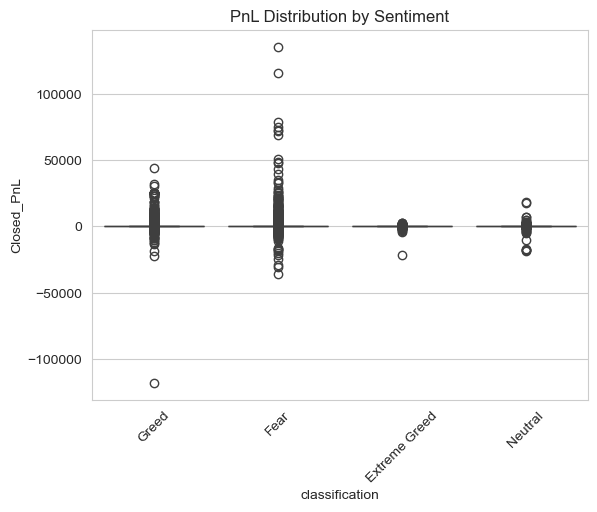

In [59]:
sns.boxplot(x='classification', y='Closed_PnL', data=df)
plt.xticks(rotation=45)
plt.title("PnL Distribution by Sentiment")
plt.show()

In [62]:
side_sentiment = df.groupby(['classification','Side']).size().unstack()
print(side_sentiment)


Side              BUY   SELL
classification              
Extreme Greed    3371   3591
Fear            66081  67790
Greed           15421  20868
Neutral          3505   3636


In [63]:
df['win'] = df['Closed_PnL'] > 0

In [64]:
win_rate = df.groupby('classification')['win'].mean()
print(win_rate)

classification
Extreme Greed    0.490089
Fear             0.415146
Greed            0.446471
Neutral          0.317182
Name: win, dtype: float64


In [65]:
print(df.columns)

Index(['Account', 'Coin', 'Execution_Price', 'Size_Tokens', 'Size_USD', 'Side',
       'Timestamp_IST', 'Start_Position', 'Direction', 'Closed_PnL',
       'Transaction_Hash', 'Order_ID', 'Crossed', 'Fee', 'Trade_ID',
       'Timestamp', 'Date', 'classification', 'win'],
      dtype='object')


In [66]:
performance = df.groupby('classification')['Closed_PnL'].agg(['mean','median','count'])
print(performance)

                     mean  median   count
classification                           
Extreme Greed   25.418772     0.0    6962
Fear            50.047622     0.0  133871
Greed           87.894859     0.0   36289
Neutral         22.229713     0.0    7141


In [67]:
df['classification'].value_counts()

classification
Fear             133871
Greed             36289
Neutral            7141
Extreme Greed      6962
Name: count, dtype: int64

In [68]:
df['sentiment_group'] = df['classification'].replace({
    'Extreme Fear': 'Fear',
    'Fear': 'Fear',
    'Neutral': 'Neutral',
    'Greed': 'Greed',
    'Extreme Greed': 'Greed'
})

In [69]:
df['sentiment_group'].value_counts()

sentiment_group
Fear       133871
Greed       43251
Neutral      7141
Name: count, dtype: int64

In [70]:
performance = df.groupby('sentiment_group')['Closed_PnL'].agg(['mean','median','std','count'])
print(performance)

                      mean  median          std   count
sentiment_group                                        
Fear             50.047622     0.0   909.121796  133871
Greed            77.838247     0.0  1059.262203   43251
Neutral          22.229713     0.0   633.704815    7141


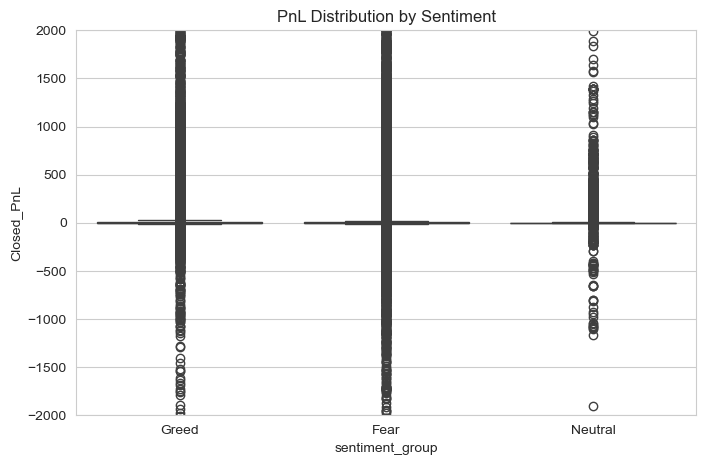

In [71]:
plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment_group', y='Closed_PnL', data=df)
plt.ylim(-2000, 2000)  # adjust after checking range
plt.title("PnL Distribution by Sentiment")
plt.show()

In [72]:
df['win'] = df['Closed_PnL'] > 0

win_rate = df.groupby('sentiment_group')['win'].mean()
print(win_rate)

sentiment_group
Fear       0.415146
Greed      0.453492
Neutral    0.317182
Name: win, dtype: float64


In [73]:
win_rate * 100

sentiment_group
Fear       41.514592
Greed      45.349240
Neutral    31.718247
Name: win, dtype: float64

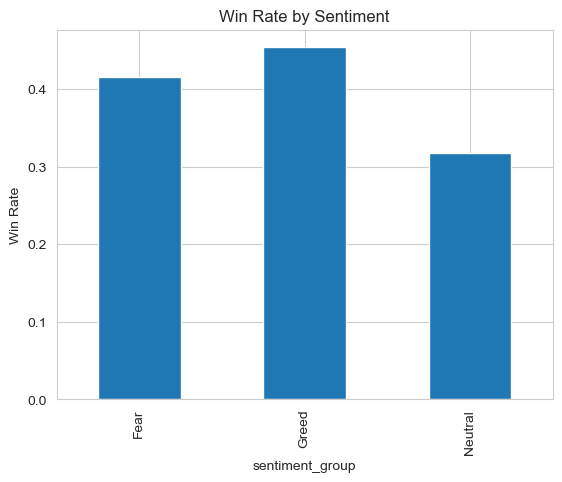

In [74]:
win_rate.plot(kind='bar')
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate")
plt.show()

In [75]:
trades_per_day = df.groupby(['Date','sentiment_group']).size().reset_index(name='trade_count')

freq_summary = trades_per_day.groupby('sentiment_group')['trade_count'].mean()
print(freq_summary)


sentiment_group
Fear       133871.00
Greed       10812.75
Neutral      7141.00
Name: trade_count, dtype: float64


In [76]:
side_analysis = df.groupby(['sentiment_group','Side']).size().unstack()
print(side_analysis)

Side               BUY   SELL
sentiment_group              
Fear             66081  67790
Greed            18792  24459
Neutral           3505   3636


In [77]:
side_analysis['Long_Short_Ratio'] = side_analysis['BUY'] / (side_analysis['SELL'] + 1)
print(side_analysis)

Side               BUY   SELL  Long_Short_Ratio
sentiment_group                                
Fear             66081  67790          0.974775
Greed            18792  24459          0.768275
Neutral           3505   3636          0.963706


In [78]:
size_analysis = df.groupby('sentiment_group')['Size_USD'].mean()
print(size_analysis)

sentiment_group
Fear       5259.977837
Greed      3581.661513
Neutral    3058.848110
Name: Size_USD, dtype: float64


In [79]:
trader_activity = df.groupby('Account').size()
median_activity = trader_activity.median()

df['activity_group'] = df['Account'].map(
    lambda x: 'Frequent' if trader_activity[x] > median_activity else 'Infrequent'
)

In [80]:
df.groupby(['activity_group','sentiment_group'])['Closed_PnL'].mean()

activity_group  sentiment_group
Frequent        Fear                46.013950
                Greed               62.926547
                Neutral              4.055615
Infrequent      Fear                75.639873
                Greed              226.618415
                Neutral            356.722004
Name: Closed_PnL, dtype: float64

In [81]:
median_size = df['Size_USD'].median()

df['size_group'] = df['Size_USD'].apply(
    lambda x: 'Large' if x > median_size else 'Small'
)

In [82]:
df.groupby(['size_group','sentiment_group'])['Closed_PnL'].mean()

size_group  sentiment_group
Large       Fear                95.784210
            Greed              148.341754
            Neutral             49.743021
Small       Fear                 3.233227
            Greed               11.532244
            Neutral              1.834576
Name: Closed_PnL, dtype: float64

In [83]:
df.groupby(['size_group','sentiment_group'])['Closed_PnL'].mean()

size_group  sentiment_group
Large       Fear                95.784210
            Greed              148.341754
            Neutral             49.743021
Small       Fear                 3.233227
            Greed               11.532244
            Neutral              1.834576
Name: Closed_PnL, dtype: float64

In [84]:
trader_volatility = df.groupby('Account')['Closed_PnL'].std()

median_vol = trader_volatility.median()

df['consistency_group'] = df['Account'].map(
    lambda x: 'Consistent' if trader_volatility[x] < median_vol else 'Volatile'
)

In [85]:
df.groupby(['consistency_group','sentiment_group'])['Closed_PnL'].mean()

consistency_group  sentiment_group
Consistent         Fear                10.402282
                   Greed               43.008306
                   Neutral             -2.388379
Volatile           Fear               102.956932
                   Greed              182.518382
                   Neutral             50.562763
Name: Closed_PnL, dtype: float64

In [86]:
df.groupby('sentiment_group')['Closed_PnL'].mean()

sentiment_group
Fear       50.047622
Greed      77.838247
Neutral    22.229713
Name: Closed_PnL, dtype: float64

In [87]:
df.groupby('sentiment_group')['win'].mean()

sentiment_group
Fear       0.415146
Greed      0.453492
Neutral    0.317182
Name: win, dtype: float64

In [88]:
df.groupby('sentiment_group')['Closed_PnL'].mean()
df.groupby('sentiment_group')['win'].mean()
df.groupby('sentiment_group')['Size_USD'].mean()
df.groupby('sentiment_group')['Side'].value_counts()

sentiment_group  Side
Fear             SELL    67790
                 BUY     66081
Greed            SELL    24459
                 BUY     18792
Neutral          SELL     3636
                 BUY      3505
Name: count, dtype: int64